In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [14]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", 
                "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [17]:
df = df.drop(['Date', 'Holiday', 'Seasons'], axis = 1)

In [21]:
df.columns = dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int)

In [23]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


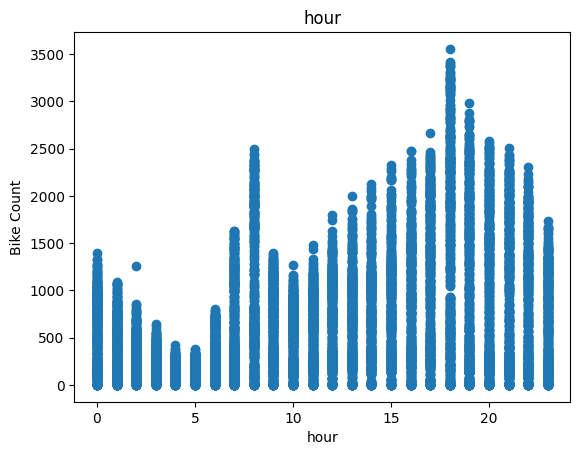

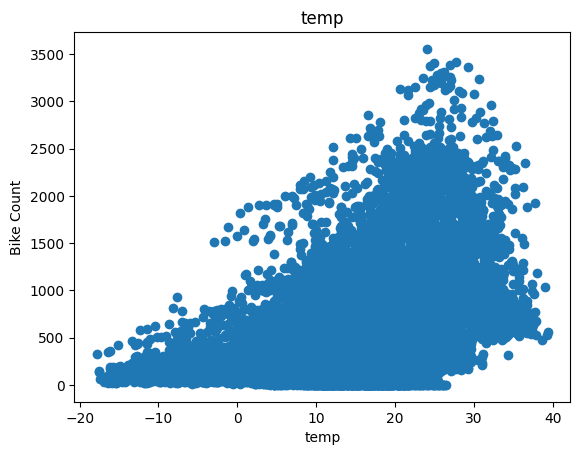

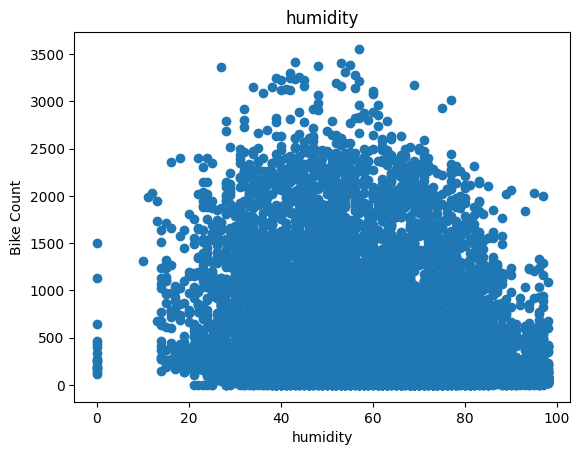

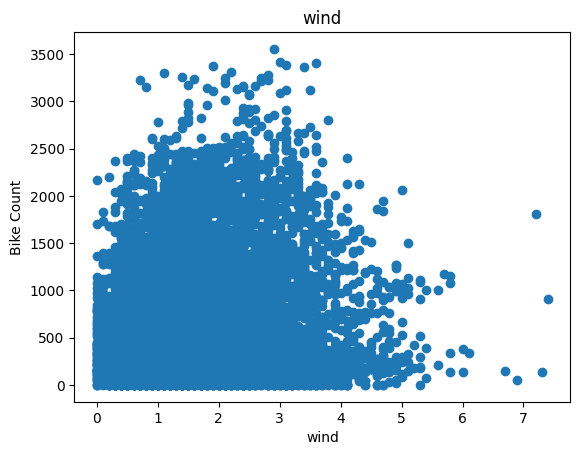

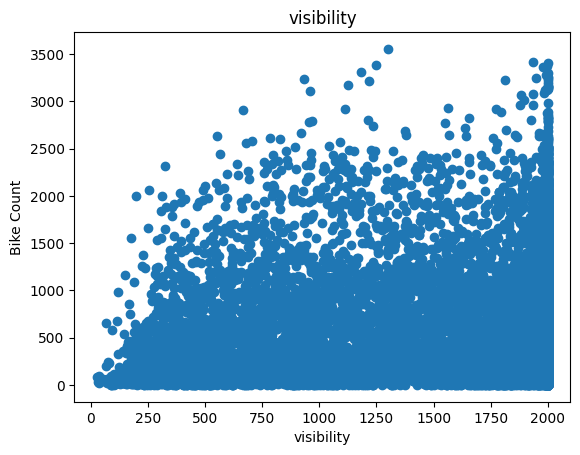

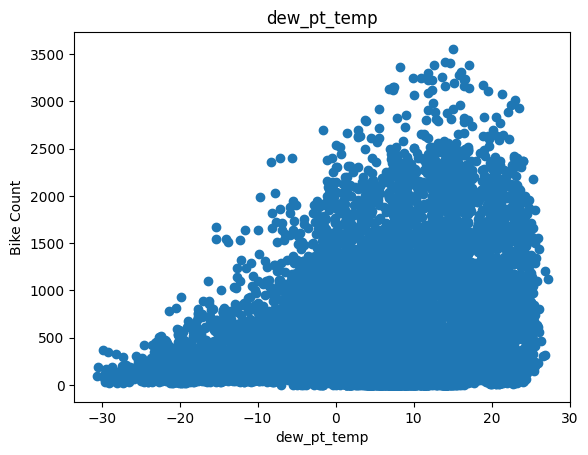

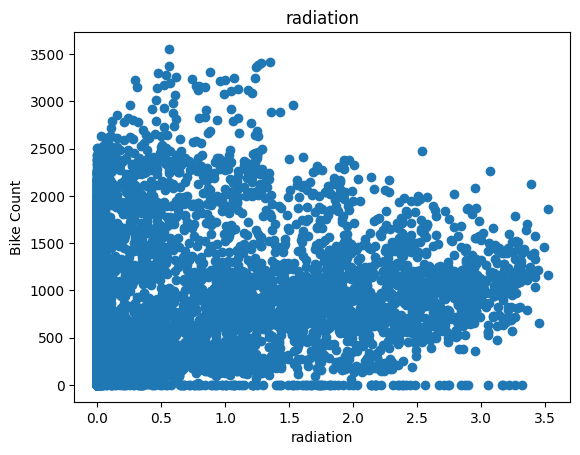

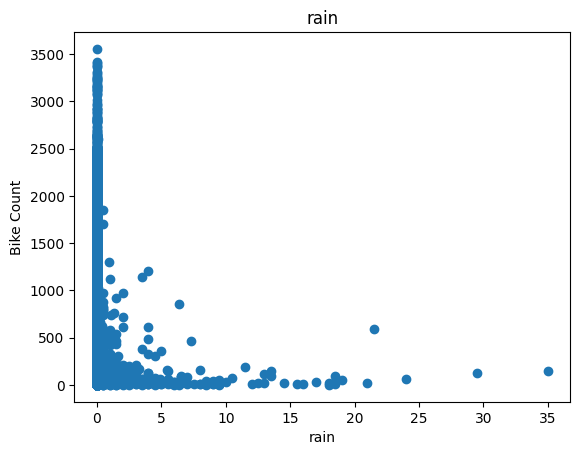

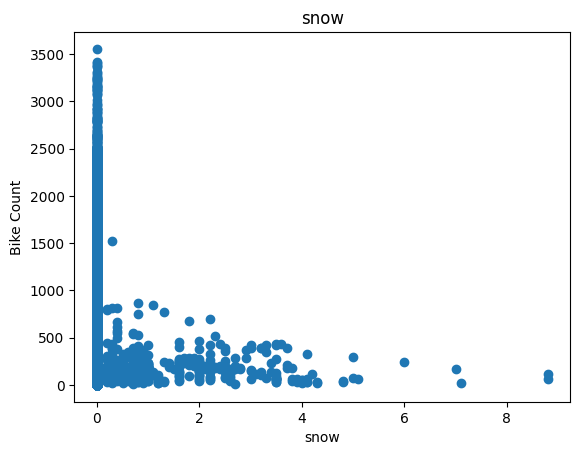

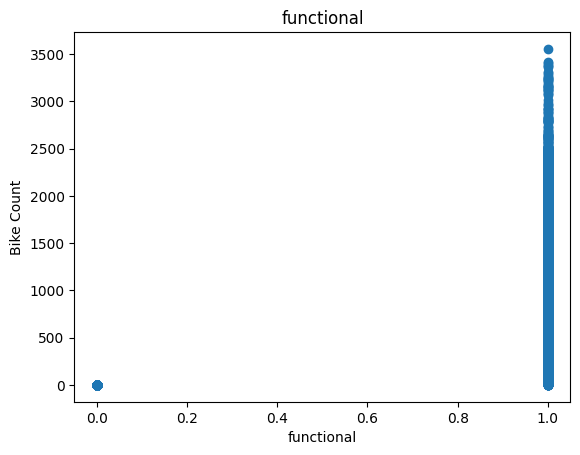

In [24]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel("Bike Count")
    plt.xlabel(label)
    plt.show()

# Train validation and test split

In [37]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [34]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
        
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
            
        else:
            X = dataframe[x_labels].values
            
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))
    
    return data, X, y

In [38]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_valid_temp, y_valid_temp = get_xy(valid, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

# Linear Regression

In [30]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [31]:
print(temp_reg.coef_, temp_reg.intercept_)

[[28.65291808]] [334.87784696]


In [32]:
temp_reg.score(X_test_temp, y_test_temp)

0.29908380165291915

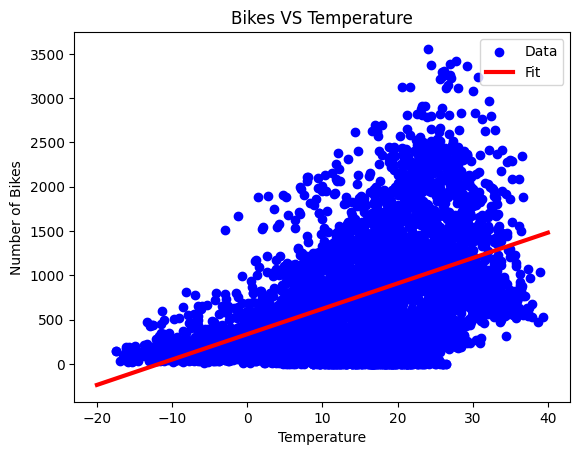

In [33]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes VS Temperature')
plt.xlabel('Temperature')
plt.ylabel('Number of Bikes')
plt.show()

# Multiple Linear Regression

In [44]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, 'bike_count', x_labels=df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, 'bike_count', x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', x_labels=df.columns[1:])

In [45]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [46]:
all_reg.score(X_test_all, y_test_all)

0.526295049072196

In [94]:
y_pred_lr = all_reg.predict(X_test_all)

# Simple Regression with Neural Net

In [47]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [48]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [49]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [50]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_valid_temp, y_valid_temp)
)

In [53]:
def plot_loss(history):
    plt.plot(history.history['loss'], 'g', label='Loss')
    plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

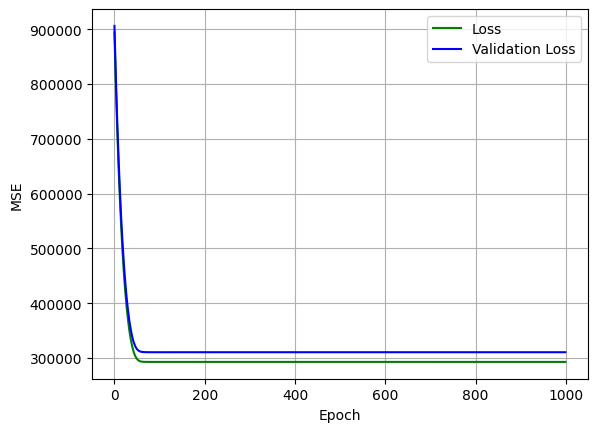

In [54]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


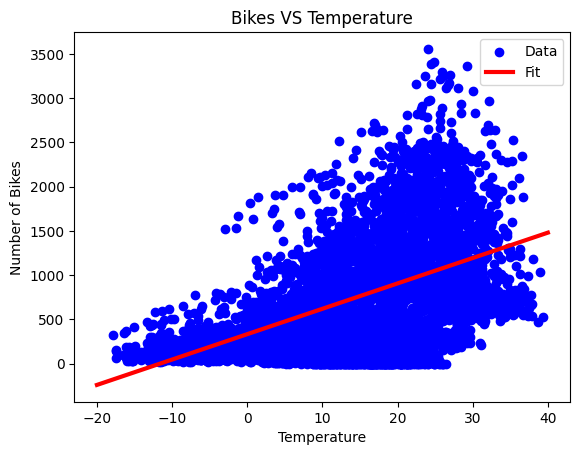

In [55]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes VS Temperature')
plt.xlabel('Temperature')
plt.ylabel('Number of Bikes')
plt.show()

# Multiple Regression with Neural Net

In [91]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(10,), axis=-1)
all_normalizer.adapt(X_train_all)

all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(1)
])

all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

history = all_nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=1000,
    validation_data=(X_valid_all, y_valid_all)
)

In [92]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MSE]')
    plt.legend()
    plt.grid(True)

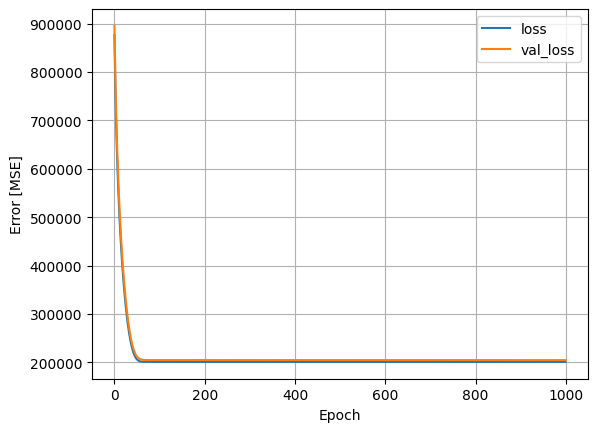

In [93]:
plot_loss(history)

In [ ]:
test_results['linear_model'] = all_nn_model.evaluate(
    X_test_all, y_test_all, verbose=0)

In [86]:
all_nn_model.evaluate(
    X_test_all, y_test_all, verbose=0)

303524.8125

# Deep Neural Net

In [87]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(10,), axis=-1)
all_normalizer.adapt(X_train_all)

In [88]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [104]:
history = nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=100,
    validation_data=(X_valid_all, y_valid_all)
)

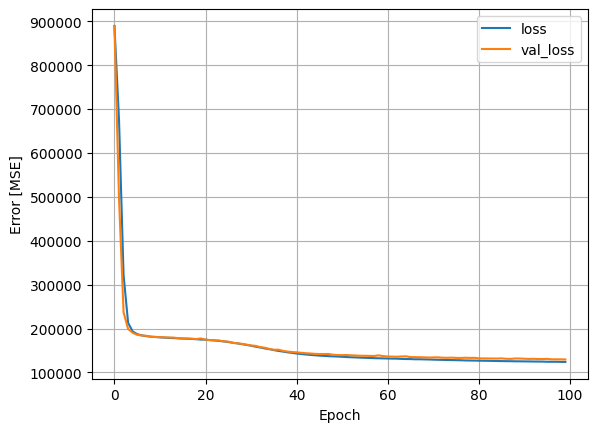

In [105]:
plot_loss(history)

In [106]:
# calculate MSE for lr and nn model
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

55/55 [==============================] - 0s 2ms/step


In [107]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [108]:
MSE(y_pred_lr, y_test_all)

188506.45870727676

In [109]:
MSE(y_pred_nn, y_test_all)

125761.34374817461

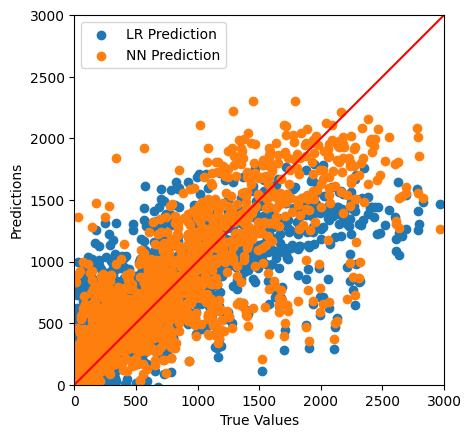

In [115]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label='LR Prediction')
plt.scatter(y_test_all, y_pred_nn, label='NN Prediction')
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 3000]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')